In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import os

In [2]:
#use_cuda = torch.cuda.is_available()
use_cuda = False
device = torch.device("cuda:0" if use_cuda else "cpu")
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [3]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder('data/train', data_transforms['train']),
    'validation': 
    datasets.ImageFolder('data/validation', data_transforms['validation'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True, num_workers=4),
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=False, num_workers=4)
}

In [4]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(3*224*224,2)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.linear(x)
        return out

In [5]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.float() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss.item(),
                                                        epoch_acc.item()))
    return model

In [6]:
LogReg = LogisticRegression()

In [7]:
LogReg.load_state_dict(torch.load('weightsLogReg.h5'))

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(LogReg.parameters())

In [9]:
LogReg_trained = train_model(LogReg, criterion, optimizer, num_epochs=20)

Epoch 1/20
----------
train loss: 23.4354, acc: 0.5995
validation loss: 64.8451, acc: 0.4952
Epoch 2/20
----------
train loss: 21.5919, acc: 0.6049
validation loss: 14.6288, acc: 0.6311
Epoch 3/20
----------
train loss: 19.8827, acc: 0.6071
validation loss: 14.3917, acc: 0.5831
Epoch 4/20
----------
train loss: 19.9679, acc: 0.6079
validation loss: 15.5160, acc: 0.6320
Epoch 5/20
----------
train loss: 18.9526, acc: 0.6103
validation loss: 12.0622, acc: 0.6543
Epoch 6/20
----------
train loss: 18.4360, acc: 0.6124
validation loss: 12.7436, acc: 0.6314
Epoch 7/20
----------
train loss: 18.7726, acc: 0.6094
validation loss: 11.7090, acc: 0.6404
Epoch 8/20
----------
train loss: 18.1211, acc: 0.6124
validation loss: 15.3790, acc: 0.6423
Epoch 9/20
----------
train loss: 17.1911, acc: 0.6153
validation loss: 25.2144, acc: 0.6009
Epoch 10/20
----------
train loss: 17.5882, acc: 0.6141
validation loss: 18.4050, acc: 0.6127
Epoch 11/20
----------
train loss: 17.2045, acc: 0.6138
validation lo

In [10]:
validation_img_paths = []
validation_y_true = []
for root, dirs, files in os.walk("data/validation/tumor"):  
    for filename in files:
        validation_img_paths.append("data/validation/tumor/"+str(filename))
        validation_y_true.append(1)
for root, dirs, files in os.walk("data/validation/no_tumor"):  
    for filename in files:
        validation_img_paths.append("data/validation/no_tumor/"+str(filename))
        validation_y_true.append(0)

In [11]:
validation_paths_splited = np.array_split(np.array(validation_img_paths),200)

In [12]:
pred_probs_list = []
for i in range(200):
    img_list = [Image.open(img_path) for img_path in validation_paths_splited[i]]
    validation_batch = torch.stack([data_transforms['validation'](img).to(device) for img in img_list])
    pred_probs_list.append(F.softmax(LogReg(validation_batch), dim=1).cpu().data.numpy())

In [13]:
pred_probs = np.concatenate([pred_probs_list[i] for i in range(200)])[:,1]

In [14]:
y_true = np.array(validation_y_true)

In [15]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, pred_probs)

In [16]:
roc_auc = roc_auc_score(y_true,pred_probs)

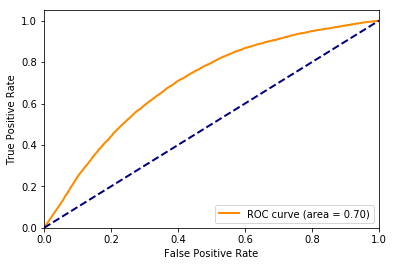

In [17]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [18]:
torch.save(LogReg_trained.state_dict(), 'weightsLogReg2.h5')